In [8]:
import pandas as pd
import LendingClubFunctions as LC
from sklearn.decomposition import PCA
import re
import sklearn as sk
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import grid_search
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
import nltk
from sklearn import tree
import numpy as np
from sklearn import preprocessing
import numpy as np
import math
from sklearn.svm import SVR
%pylab inline
pylab.rcParams['figure.figsize']=(8.0,6.0)


Populating the interactive namespace from numpy and matplotlib


# Load Data In

In [3]:
#Define data location
file1='./data/LoanStats3a.csv'
file2='./data/LoanStats3b.csv'
file3='./data/LoanStats3c.csv'
file4='./data/LoanStats3d.csv'
files=[file1,file2,file3,file4]

In [4]:
cols=['loan_amnt','funded_amnt','total_pymnt', 'loan_status', 'int_rate', 'term',
      'desc', 'grade', 'annual_inc', 'purpose', 'emp_length', 'earliest_cr_line', 
      'revol_util', 'home_ownership', 'sub_grade', 'addr_state', 'dti', 'revol_bal', 'installment']

In [5]:
#Load data in from files
df1=LC.GetData(cols, files)

/Users/admin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


# Clean The Data

In [6]:
Trouble=[ 'Charged Off', 'Default', 'Does not meet the credit policy.  Status:Charged Off']
Success=['Fully Paid', 'Does not meet the credit policy.  Status:Fully Paid']
df1=LC.CleanData(df1, Success=Success, Trouble=Trouble)

# Start With Visualization of Investors Lost Money

(array([    0.,   500.,  1000.,  1500.,  2000.,  2500.]),
 <a list of 6 Text yticklabel objects>)

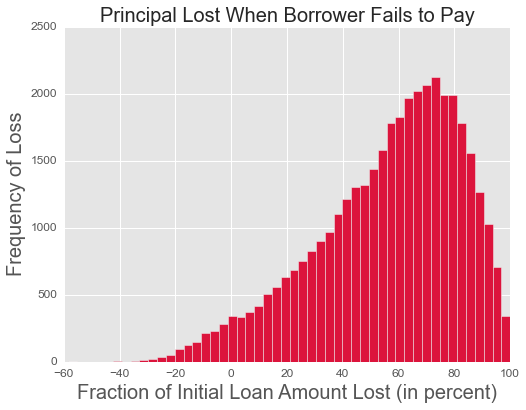

In [14]:
#Lost Principal in Defaults
ax1=plt.hist(-(df1[(df1['loan_status']==bin(0)) & (df1.funded_amnt>1)].PerLoss).as_matrix()*100, bins=50,  color='crimson', label='Charged off/in default', stacked=True, histtype='barstacked', alpha=1)
plt.xlabel('Fraction of Initial Loan Amount Lost (in percent)', fontsize=20)
plt.ylabel('Frequency of Loss', fontsize=20)
plt.title('Principal Lost When Borrower Fails to Pay', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


(array([    0.,   500.,  1000.,  1500.,  2000.,  2500.]),
 <a list of 6 Text yticklabel objects>)

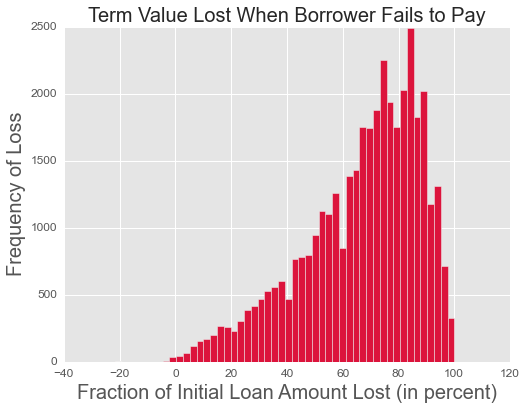

In [17]:
#Lost Term Value in Defaults
ax1=plt.hist((-(df1[(df1['loan_status']==bin(0)) & (df1.funded_amnt>1)].PerLossTerm)/(df1.term[(df1['loan_status']==bin(0)) & (df1.funded_amnt>1)]**2)).as_matrix()*100, bins=50,  color='crimson', label='Charged off/in default', stacked=True, histtype='barstacked', alpha=1)
plt.xlabel('Fraction of Initial Loan Amount Lost (in percent)', fontsize=20)
plt.ylabel('Frequency of Loss', fontsize=20)
plt.title('Term Value Lost When Borrower Fails to Pay', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Visualization By State

In [18]:
grouped=df1.groupby(['addr_state', 'loan_status'])
bystate=grouped.count().loan_amnt.dropna()
bystateIntRate=df1.groupby(['addr_state']).mean().int_rate
StateData=pd.DataFrame([bystate[state].as_matrix() for state in df1.addr_state.dropna().unique()], index=df1.addr_state.dropna().unique(), columns=['Active', 'Defaulted', 'Paid'])
StateData['State']=StateData.index
StateData['IntRate']=100*bystateIntRate
StateData['Total']=StateData.sum(axis=1)
StateData['DefaultRate']=100*StateData['Defaulted']/StateData['Total']
StateData['Country']='USA'
StateData=StateData[StateData.Total>1000]
StateData.to_csv('./Defaults_by_State.csv', columns=['State', 'Country', 'DefaultRate', 'Total', 'IntRate'], index=False)

In [19]:
#The above data was used to create the cartodb plot on the web app

# Plot Default Rates as a Function of Different Features

In [24]:
class PlaceLoanAmnt:
    def __init__(self):
        self.bins=None
        self.groupnames=None
        self.DFrates=None
    
    def GetInfo(self, value):
        for i in range(len(self.bins)-1):
            if self.bins[i]<=value<self.bins[i+1]:
                return self.groupnames[i]
        if value<self.bins[0]:
            return self.groupnames[0]
        else:
            return self.groupnames[-1]

def ExploreDefaultRate(df1, attribute, Nbins=10, filename='nothing', MakeDill=False, xlabel=None, xmult=1, SaveFig=True):
    
    if not xlabel:
        xlabel=attribute
    
    dx=1./Nbins
    bins=df1[attribute].quantile(np.arange(0,1, dx))
    BINS=pd.Series(df1[attribute].quantile(np.arange(0,1-dx, dx)).as_matrix(), index=range(0,Nbins-1))
    group_names=range(0,len(bins)-1)
    categories = pd.cut(df1[attribute], bins, labels=group_names)
    try:
         df1.drop('LACat', axis=1, inplace=True)
    except:
        pass
   
    df1['LACat']=categories
    byLACat=df1.dropna().groupby(['LACat', 'loan_status'])['LACat'].count()
    LoanCatdf=pd.DataFrame([byLACat[Cat] for Cat in df1.LACat.dropna().unique()], index=df1.LACat.dropna().unique())
    LoanCatdf.columns=['Active', 'Defaulted', 'Paid']
    LoanCatdf['Total']=LoanCatdf['Active']+LoanCatdf['Defaulted']+LoanCatdf['Paid']
    LoanCatdf['DefaultRate']=100.*LoanCatdf['Defaulted']/LoanCatdf['Total']
    AboutLoanAmount=PlaceLoanAmnt()
    AboutLoanAmount.bins=bins.as_matrix()
    AboutLoanAmount.groupnames=group_names
    AboutLoanAmount.DFrates=LoanCatdf
    if MakeDill:
        file1=open(filename+".txt", 'w')
        A=dill.dumps(AboutLoanAmount)
        print >> file1, A
        file1.close()

    
    LoanCatdf=LoanCatdf.sort_index()
    LoanCatdf['bin']=BINS
    plt.plot(xmult*LoanCatdf.bin, LoanCatdf.DefaultRate, '-')
    plt.xlabel(xlabel,fontsize=25)
    plt.ylabel("Default Rate",fontsize=25)
    plt.tick_params(axis='both', which='major', labelsize=15)
    if SaveFig:
        plt.savefig(filename+".png")
    
    return

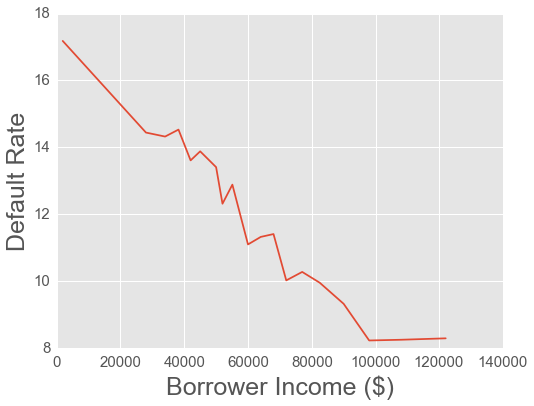

In [25]:
ExploreDefaultRate(df1, 'annual_inc', Nbins=20, filename='BorrowerIncome', MakeDill=False, xlabel='Borrower Income ($)')

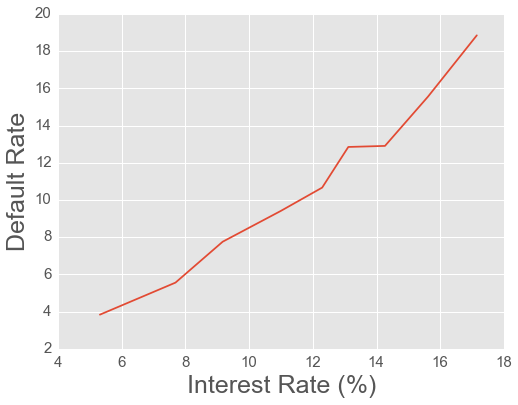

In [26]:
ExploreDefaultRate(df1, 'int_rate', Nbins=10, filename='InterestRate', MakeDill=False, xlabel='Interest Rate (%)', xmult=100)

# Interest Rate Categories

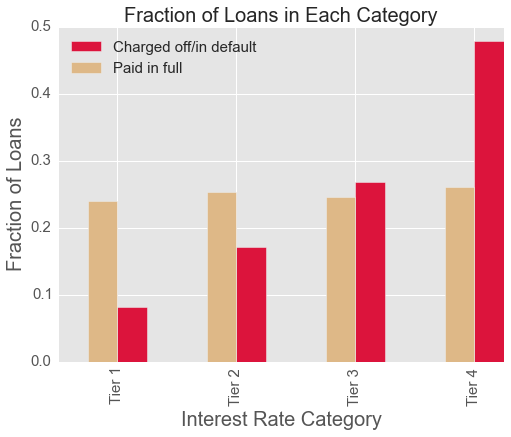

In [28]:
grouped=df1.groupby(['loan_status', 'IntCat'])
PaidRates=(grouped.count()['int_rate'])['0b1']/((grouped.count()['int_rate'])['0b1'].sum())
LostRates=(grouped.count()['int_rate'])['0b0']/((grouped.count()['int_rate'])['0b0'].sum())

ax4=LostRates.plot(kind='bar', color='crimson', position=0, width=.25, label='Charged off/in default', fontsize=15)
ax5=PaidRates.plot(kind='bar', color='burlywood', position=1, width=.25, label= 'Paid in full', fontsize=15)
ax4.set_xlabel('Interest Rate Category')
ax4.set_ylabel('Fraction of Loans')
ax4.set_title('Fraction of Loans in Each Category')
plt.legend( loc='best', prop={'size':15})
ax4.xaxis.label.set_fontsize(20)
ax4.yaxis.label.set_fontsize(20)
ax4.title.set_fontsize(20)

# Term Value of Loans

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ]),
 <a list of 6 Text yticklabel objects>)

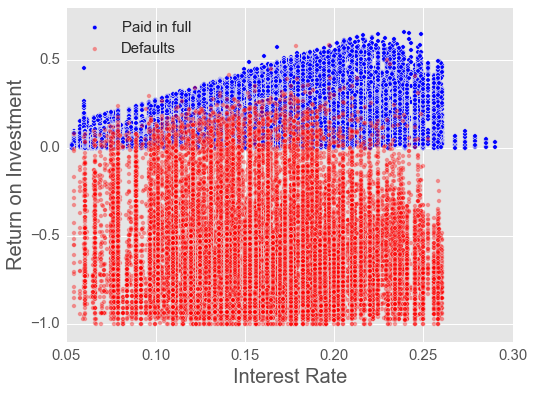

In [86]:
#Plot of the return of investment on all completed loans
ax=df1[(df1.loan_status!=bin(0)) & (df1.loan_status!=2)].plot(x='int_rate', y='ROI', kind='scatter', color='blue', xlim=(0.05,0.3), ylim=(-1.1, .8), label='Paid in full')
df1[(df1.loan_status!=bin(1)) & (df1.loan_status!=2)].plot(x='int_rate', y='ROI', kind='scatter', ax=ax, color='red', alpha=.4, label='Defaults')
ax.legend(loc='upper left', fontsize=15)
ax.set_xlabel('Interest Rate', fontsize=20)
ax.set_ylabel('Return on Investment', fontsize=20)
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.title.set_fontsize(20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#ax.set_yticks({'fontsize':12})

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

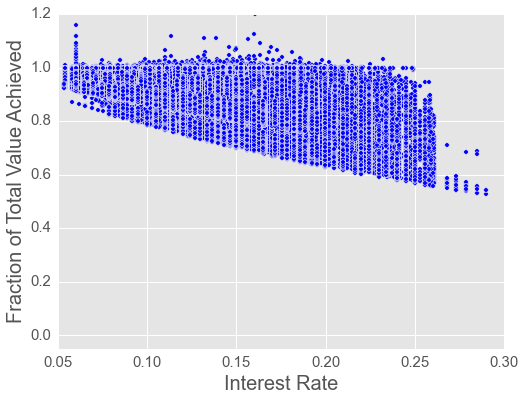

In [80]:
#Plot of how much of the naive term value loans that are paid off actually achieve
df1['Fraction_Of_Total']=df1.total_pymnt/(df1.installment*df1.term)
ax=df1[(df1.loan_status!=bin(0)) & (df1.loan_status!=2)].plot(x='int_rate', y='Fraction_Of_Total', kind='scatter', color='blue', xlim=(0.05,0.3), ylim=(-.05, 1.2))
ax.legend(loc='upper left')
ax.set_xlabel('Interest Rate', fontsize=20)
ax.set_ylabel('Fraction of Total Value Achieved', fontsize=20)
ax4.xaxis.label.set_fontsize(20)
ax4.yaxis.label.set_fontsize(20)
ax4.title.set_fontsize(20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [54]:
#Repayment term of paid off loans
def GetNano(x):
    return x.value

df3=LC.GetData(['last_pymnt_d', 'issue_d','term', 'loan_status'], files)

df1['Payment_Length']=12.*(pd.to_datetime(df3.last_pymnt_d).apply(GetNano)-pd.to_datetime(df3.issue_d).apply(GetNano))/(10**9*60.*60.*24.*365.)
payment_time=df1[df1.loan_status==bin(1)][['loan_status','Payment_Length', 'term', 'ROIAnnualized','int_rate', 'grade']].copy()


(array([     0.,   5000.,  10000.,  15000.,  20000.,  25000.,  30000.]),
 <a list of 7 Text yticklabel objects>)

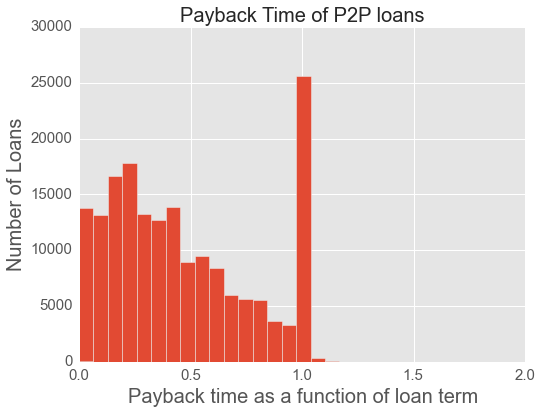

In [84]:
#Over all loans
payment_time['Difference']=(payment_time.Payment_Length)/payment_time.term
ax=payment_time.Difference.hist(bins=30)
ax.set_xlabel('Payback time as a function of loan term', fontsize=20)
ax.set_ylabel('Number of Loans', fontsize=20)
ax.set_title('Payback Time of P2P loans')
ax.title.set_fontsize(20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

(array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.]),
 <a list of 8 Text yticklabel objects>)

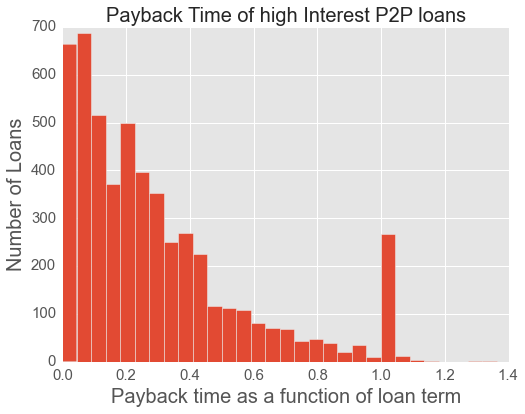

In [85]:
#Over high interest loans
ax=payment_time[(payment_time.grade=='G')|(payment_time.grade=='F')].Difference.hist(bins=30)
ax.set_xlabel('Payback time as a function of loan term', fontsize=20)
ax.set_ylabel('Number of Loans', fontsize=20)
ax.set_title('Payback Time of high Interest P2P loans', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Bokeh Plots for Web App


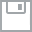
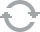
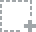
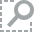
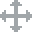
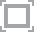
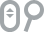
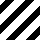
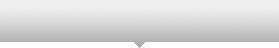
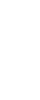
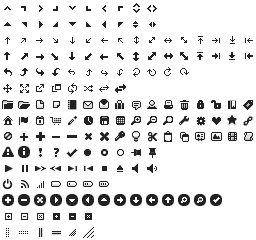
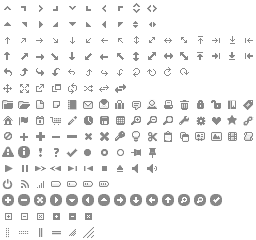
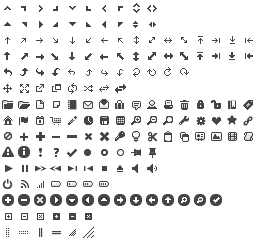
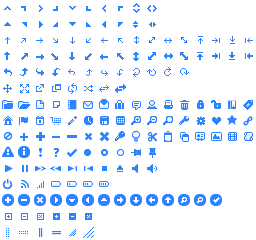
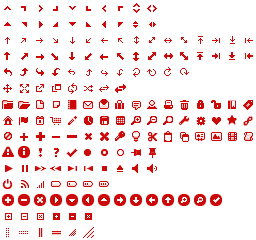
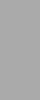
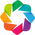
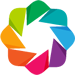

In [88]:
from bokeh.plotting import figure, output_file, show
from bokeh.embed import components
from bokeh.plotting import *
import dill
output_notebook()

In [137]:

Names=['Loan Amount', 'Borrower Income', 'Loan Interest Rate', 'Borrower Credit Utilization']
Labels=['Loan Amount (1000\'s of $)', 'Borrower Income  (1000\'s of $)', 'Loan Interest Rate (%)', 'Borrower Credit Utilization (%)']
Ops=[1.0/1000, 1.0/1000, 100, 100]
Feats=['loan_amnt','annual_inc','int_rate','revol_util' ]
Tiers=['Tier 1', 'Tier 2', 'Tier 3', 'Tier 4']
Limits=[35000, 200000, 1, 1]

In [144]:
for Tier in Tiers:
    for f,n,l,op, lim in zip(Feats, Names, Labels, Ops, Limits):
        p1 = figure(title="                "+Tier+" by "+n,
       background_fill="#E8DDCB", x_axis_label=l, y_axis_label='Fraction of Borrowers', width=800, height=400)
        hist1, edges1 = np.histogram((op*df1[(df1.loan_status==bin(0))&(df1.IntCat==Tier)&(df1[f]<lim)][f]).dropna().as_matrix(), density=True, bins=20)
        hist2, edges2 = np.histogram((op*df1[(df1.loan_status==bin(1))&(df1.IntCat==Tier)&(df1[f]<lim)][f]).dropna().as_matrix(), density=True, bins=20)
        p1.min_border_left=150
        p1.quad(top=hist2, bottom=0, left=edges2[:-1], right=edges2[1:], fill_color="burlywood", line_color="#033649", legend='Paid')
        p1.quad(top=hist1, bottom=0, left=edges1[:-1], right=edges1[1:], fill_color="crimson", line_color="#033649", alpha=.5, legend='Defaulted')
        show(p1)
        f1=open('./Bokehs/'+Tier+f, 'w')
        print >> f1, dill.dumps(p1)
        f1.close()

